Clustering problem is a type of unsupervised machine learning. Main task of clustering is to separate (group) objects (samples) wihtout explained pattern. In classification task we have got some features and labels, which should be explained by given features. Unsupervised learning problem do not provide any labels. That means an interpretation of results play a significat role. 

This projest covers an exaple of clustering problem. We are provided with dataset which describes the record of visited subpages  on msnbc.com/ website. Each sample represents one session (one user) and whole dataset has been collected on one day. Our task is to partition sessions (users) in "some" meaningful way. Such a segmenation should provide an instight in website users' activities/habits. In effect site administrators or executives will be able to transform this knowledge into business value (advertisment, webpage content, layout, etc.).

This notebook presents a complete solution of given segmenation problem. It is not a comprehensive way to solve any kind of clustering task but only proposed author's apporoach to this particular dataset. Workflow of this notebook is as follows:
1. Raw data analysis and preprocessing
2. Dimensionality reduction
3. Clustering
4. Presentation of results

So, here we are:

After all, we need to import neccessary libreries:

In [274]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans, DBSCAN
import hdbscan
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score
import time
#conda install -c conda-forge pynndescent
import pynndescent # soft dependency for umap
import numba.targets # soft dependency for umap
import umap
from scipy import sparse as sp

# 1. Data read and preprocessing 

Our data comes from UCI database: https://kdd.ics.uci.edu/databases/msnbc/. In that folder can be find *.gz archive with *.seq data file. All we need is to download, extract and place it in our local `Data` folder. 

### 1.a. Data loading

Structure of dataset looks as beneath. In one line we've got ordered names of subpage categories and few lines below starts regular data:

In [2]:
data_raw = pd.read_table("Dane/msnbc990928.seq")
data_raw.head()

% Different categories found in input file:
0  frontpage news tech local opinion on-air misc ...
1                                       % Sequences:
2                                               1 1 
3                                                 2 
4                                 3 2 2 4 2 2 2 3 3

Let's read names of categories:

In [251]:
with open("Data/msnbc990928.seq") as reader:
    lines = []
    for i in range(3):
        line = reader.readline().strip()
        lines.append(line)
categories = lines[2].split(' ')
print(categories)

['frontpage', 'news', 'tech', 'local', 'opinion', 'on-air', 'misc', 'weather', 'msn-news', 'health', 'living', 'business', 'msn-sports', 'sports', 'summary', 'bbs', 'travel']


Next we load raw data to pandas dataframe (we skipping firsts five rows)

In [29]:
data_raw = pd.read_table("Data/msnbc990928.seq", skiprows=5)
data_raw.head(3)

% Sequences:
0                1 1 
1                  2 
2  3 2 2 4 2 2 2 3 3

As we can see each row (record of one user/session) is coded with a sequence of numbers 1...17 which represents visited subpages (categories). Numbers correspond with our `categories` list (but ordered from 1 not 0). For exapmple: row `0` represents user who opend two times `frontpage` and row `1` represents someone who opend only `news`.

### 1.b. EDA

After applying any algoritms and machine learning methods we should look a bit closer to our data. 

In [5]:
lengths = data_raw.applymap(lambda x: len(x.split(' '))-1)
lengths.head(3)

% Sequences:
0             2
1             1
2             9

In [6]:
lengths.describe().T

count      mean        std  min  25%  50%  75%      max
% Sequences:  989818.0  4.747129  21.257389  1.0  1.0  2.0  5.0  14795.0

We have got 989818 samples. Median of visited pages is 2. There are also a few samples with much bigger number of visited pages (maximum sequence lenght is 14795):

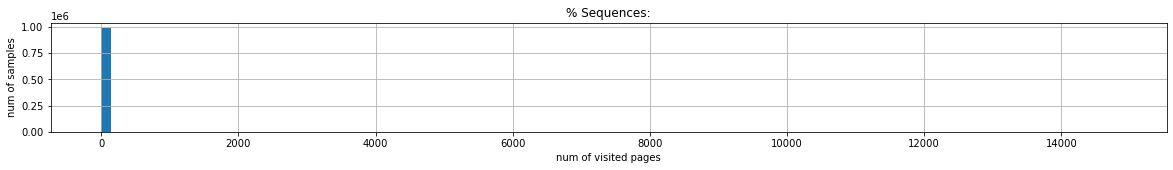

In [7]:
lengths.hist(figsize=(20,2), bins=100)
plt.xlabel('num of visited pages')
plt.ylabel('num of samples')
plt.show()

In [8]:
print("Number of samples with more than 100 visited pages: ", lengths[lengths['% Sequences:'] > 100].shape[0])
print("Number of samples with more than 500 visited pages: ", lengths[lengths['% Sequences:'] > 500].shape[0])

Number of samples with more than 100 visited pages:  535
Number of samples with more than 500 visited pages:  36


### 1.c. Data preprocessing - looking for the best representation

As our data is coded as a sequence of numbers representing particular pages/categories it is not "computing friendly" format. What need to be done is a processing each row to a format readible by ML algorithms. 
   
First idea that usualy comes in prolems like this is vectorization of data (like in bag-of-words problem). In our case we have got 17 categories, that means we should represent samples as 17-dimensional vectors. Number in each feature  would stand for amount of visited pages of particulat category. Like this:

In [9]:
# token_pattern: one-or-more-character 'words'(numbers), ngram_range(1,1) - count every single 'word' (number)
cv = CountVectorizer(token_pattern='(?u)\\b\\w+\\b', ngram_range=(1, 1))
# as input to fit_transform method is passed column of values forom data_raw DataFrame 
data_cv = cv.fit_transform(data_raw.iloc[:,0].values)

In [10]:
print("First 3 rows of vectorized data: ")
print("Please note that order of features (our categories) has changed in effect of applying CountVectorizer:\n", \
      cv.get_feature_names())
data_cv[:3, :].todense()

First 3 rows of vectorized data: 
Please note that order of features (our categories) has changed in effect of applying CountVectorizer:
 ['1', '10', '11', '12', '13', '14', '15', '16', '17', '2', '3', '4', '5', '6', '7', '8', '9']


matrix([[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 3, 1, 0, 0, 0, 0, 0]], dtype=int64)

New representation of data seems to be good enough to than use ML tools. But... 
Please note, for example, at row #2. We have stored information about number of each category visited (per session/user).

In [11]:
print("Raw data sequence: ", data_raw.iloc[2 ,:].values)
print("Vectorized sample", data_cv[2, :].todense())

Raw data sequence:  ['3 2 2 4 2 2 2 3 3 ']
Vectorized sample [[0 0 0 0 0 0 0 0 0 5 3 1 0 0 0 0 0]]


We definetly lost information about an order of visited categories. Such a loss at a very beginning of work! The idea which help us preserve more information from raw sequention is simple: to save changes of category. It means we will count every two neighboring numbers (categories) in raw seqence - such like vectorizing bigrams in text. but after that we add to every sample in raw data (pandas DataFrame) `0` at the beginning and `18` at the end of sequence. This help us 'remember' which page was first and which was last in the session. To assure each pair of neighboring numbers (0...18) was added an artificial `full_row` as follows:

In [30]:
# create 'formatting row' - a sequence with all possible pairs of numbers 0...18
full_row = ' '.join( [f"{i} {j}" for i in range(19) for j in range(19)] ) 
# add to raw data DataFrame 0 (as start session) and 18 as (end of session)
data_ext = data_raw.applymap(lambda row: "0 "+ row +" 18")
# insert at the end a `full_row`
data_ext.loc[data_ext.shape[0]] = full_row
data_ext.tail(3)

% Sequences:
989816                                0 1 1 1 1 1 1 1  18
989817                                            0 6  18
989818  0 0 0 1 0 2 0 3 0 4 0 5 0 6 0 7 0 8 0 9 0 10 0...

In [31]:
# token_pattern: one-or-more-character 'words'(numbers), ngram_range(2,2) - bigrams only (each neighboring numbers)
cv = CountVectorizer(token_pattern='(?u)\\b\\w+\\b', ngram_range=(2, 2))
# as input to fit_transform method is passed column of values forom data_raw DataFrame 
data_cv = cv.fit_transform(data_ext.iloc[:,0].values)
# drop prevoisly added 'formatting' row
data_cv = data_cv[:-1, :]
data_cv.shape

(989818, 361)

In [33]:
# CountVectorizer left features in alphabetical order - here we reordered them to ascending
features = cv.get_feature_names()
# save features as a list of 2-element (int) tuples 
features = [(int(ft.split(' ')[0]), int(ft.split(' ')[1])) for ft in features]
# convert list to an array - to enable tuple sorting 
features = np.array(features, dtype=[('current', 'i8'),('next', 'i8')])
# save 'right' order of indices 
features_idx = np.argsort(features)
# reordering of fetures in data
data_cv = data_cv[:, features_idx]

Dimension of data (number of features) has grown up to 361 ($19^{2}$). As an example beneath is presented row #2 in 19 by 19 table (DataFrame - only for explanation what has been done).

In [34]:
print("Raw data: ", data_raw.iloc[2,:].values)
tmp = data_cv[2,:].todense().reshape(-1, 19)
pd.DataFrame(tmp, index=range(19), columns=range(19))

Raw data:  ['3 2 2 4 2 2 2 3 3 ']


0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18
0   0  0  0  1  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0
1   0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0
2   0  0  3  1  1  0  0  0  0  0   0   0   0   0   0   0   0   0   0
3   0  0  1  1  0  0  0  0  0  0   0   0   0   0   0   0   0   0   1
4   0  0  1  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0
5   0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0
6   0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0
7   0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0
8   0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0
9   0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0
10  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0
11  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0
12  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0
13  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0
14  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0
15  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0
16  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0
17  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0
18  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0

So far so good, but we haven't finish yet puzzles with data representation. As numbers in table above (table is just a reshaped 361-dim vector) symbolize amount of category changes, we'd rather like to have some normalized values. This approach led us to *transition matrix* and concept of *Markov Chains*. To put it briefly: values in *transition matrix* stand for likelihood of transisions between nodes (page categories in this case). One of rules in building *transition matrix* is: each to non-only-zeros row must to be summed to 1 (likelihood == 1). So, what we have to do is dividing each row (where is something more that 0) by sum of numbers in this row. To be clear, theoretical model utilized in this data transformation is **Markov Chains of 1st order** where probability of next node depends only on current position. While in Markov Chains of order k next node depends on previous k positions. It seems that higher order of Markov Chains should better models behaviour in the web. Surprisingly this paper https://arxiv.org/abs/1402.0790 confirms that higher order model does not reward additional complexity with better results. 

In [16]:
def build_transistion_matrix(row: np.ndarray) -> np.ndarray:
    row = np.asarray(row).ravel()
    tm_dim = np.sqrt(row.shape[0]).astype(int) 
    # reshape one row (here 361-dim vector) to 19x19 array (matrix)
    row = row.reshape(tm_dim, -1) 
    # take sum of each row in built matrix, when row consist of zeros only then take 1
    den = np.maximum(row.sum(1), np.ones(shape=row.shape[0])) 
    # divide each row by its sum
    row = np.divide(row, den.reshape(-1,1))
    # returns transision matrix reshaped to 361-dim vector
    return row.ravel() 

In [17]:
start_time = time.time()
X = np.apply_along_axis(func1d=build_transistion_matrix, axis=1, arr=data_cv.todense())
print("%s seconds" % (time.time() - start_time))

25.10293459892273 seconds


And go back to example of row #2. How to read information coded in form of *transition matrix*? Rows' indices represent nodes 'from' and columns' indices stand for 'to' nodes. So, sequention starts from category #3 (0->3 likelihood eqals 1), being in category #3 sequence can go to #2 (33% chance), stay on #3 (33% chance) or end session (3->18, 33% chance). From category #2 sequence can go to #3 or #4 (both 20% chance) or more likely stan on #2 (60% chance).From category #4 with no doubts sequence will go to #2 (likelihood = 1).

In [18]:
tmp = X[2].reshape(19,19)
pd.DataFrame(tmp, index=range(19), columns=range(19))

0    1         2         3    4    5    6    7    8    9   10   11   12  \
0   0.0  0.0  0.000000  1.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1   0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2   0.0  0.0  0.600000  0.200000  0.2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3   0.0  0.0  0.333333  0.333333  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4   0.0  0.0  1.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
5   0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6   0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7   0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8   0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
9   0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
10  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
11  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
12  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
13  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
14  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
15  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
16  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
17  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
18  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

     13   14   15   16   17        18  
0   0.0  0.0  0.0  0.0  0.0  0.000000  
1   0.0  0.0  0.0  0.0  0.0  0.000000  
2   0.0  0.0  0.0  0.0  0.0  0.000000  
3   0.0  0.0  0.0  0.0  0.0  0.333333  
4   0.0  0.0  0.0  0.0  0.0  0.000000  
5   0.0  0.0  0.0  0.0  0.0  0.000000  
6   0.0  0.0  0.0  0.0  0.0  0.000000  
7   0.0  0.0  0.0  0.0  0.0  0.000000  
8   0.0  0.0  0.0  0.0  0.0  0.000000  
9   0.0  0.0  0.0  0.0  0.0  0.000000  
10  0.0  0.0  0.0  0.0  0.0  0.000000  
11  0.0  0.0  0.0  0.0  0.0  0.000000  
12  0.0  0.0  0.0  0.0  0.0  0.000000  
13  0.0  0.0  0.0  0.0  0.0  0.000000  
14  0.0  0.0  0.0  0.0  0.0  0.000000  
15  0.0  0.0  0.0  0.0  0.0  0.000000  
16  0.0  0.0  0.0  0.0  0.0  0.000000  
17  0.0  0.0  0.0  0.0  0.0  0.000000  
18  0.0  0.0  0.0  0.0  0.0  0.000000

Once our dataset is prepared for applying ML algorithms let's take a look on some example plots. We can now visualise likelihood of first page category open in session. It is `Frontpage` which is not a big surprise. But what is interesting, `On-Air` is most probable category where users were closing session on msnbc.com. 

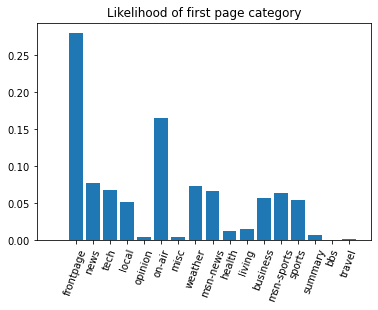

In [19]:
start_page = X[:, :18].mean(0)
plt.bar(range(18), start_page)
plt.xticks(ticks=range(1, 18),labels=categories, rotation=70)
plt.title('Likelihood of first page category')
plt.show()

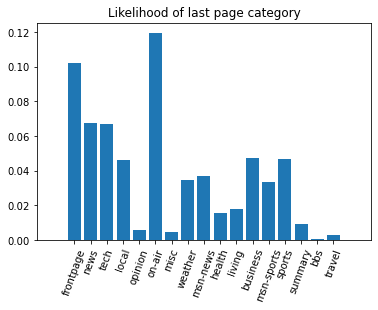

In [20]:
last_page = X[:, range(18,361,19)].mean(0)
plt.bar(range(19), last_page)
plt.xticks(ticks=range(1, 18),labels=categories, rotation=70)
plt.title('Likelihood of last page category')
plt.show()

# 2. Dimensionality reduction

Our dataset dimension has grown above 360. Having such a big number of features bring along a problem with computation time - clustering algoritms will generally **work faster** with fewer features. Reducing the the number of features losses of course some information but we achive instead better performance of algorithms in next steps.

In clustering problems dimensionality reduction gives us also advantage of ability to **visualize a dataset** on 2d plot. To do this it is necessary to extremely reduce number of features (from 361 to 2). T-SNE and UMAP algorithms are able to compress data dimesions and preserve at the same time main dependencies between samples. Having this insight to these patterns we can manually evaluate results of clustering. Unfortunately for large datasets T-SNE is not efficient and won't be utilized with final results. But we will show how this method perform on subset of our data. 

In our case will be presented 3 dimensinality reduction algorithms: 
- well known linear method - **PCA** - as an initial step;
- manifold methods **T-SNE** form sklearn package;
- and **UMAP** - another manifold method. 

Before get to reduction of irrelevant features we need to normalize data (*X*). 

In [21]:
X_n = Normalizer('l1').fit_transform(X)

### PCA

Below we try to reduce a dimension of data that preserve 90% of oryginal variance (an arbitrary chosen value).
Having such an opportuinty, has been presented effect of data normalization: how to retain same percent of variance with fewer features.

In [22]:
pca_norm = PCA().fit(X_n)
pca_raw = PCA().fit(X)

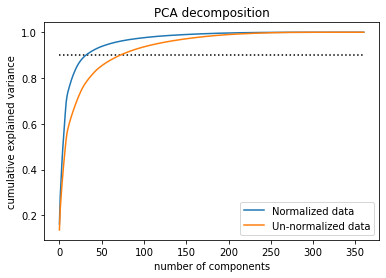

In [23]:
plt.plot(np.cumsum(pca_norm.explained_variance_ratio_), label='Normalized data')
plt.plot(np.cumsum(pca_raw.explained_variance_ratio_), label='Un-normalized data')
plt.hlines(0.9, 0, 360, linestyles='dotted', colors='k')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('PCA decomposition')
plt.legend()
plt.show()

In [24]:
print("PCA on unnormalized data - number of components to explain 90% of variance: ", 
      np.where( np.cumsum(pca_raw.explained_variance_ratio_) >=0.9, True, False).argmax()+1)
print("PCA on normalized data - number of components to explain 90% of variance: ", 
      np.where( np.cumsum(pca_norm.explained_variance_ratio_) >=0.9, True, False).argmax()+1)

PCA on unnormalized data - number of components to explain 90% of variance:  73
PCA on normalized data - number of components to explain 90% of variance:  33


In [26]:
X_pca = PCA(0.9).fit_transform(X_n)
X_pca.shape

(989818, 33)

#### Technical remark.
Need to reset memory (release RAM) due to limited resources (16GB). After that we store in files arrays which will be processed in the next steps. 

In [27]:
sp.save_npz('Data/X_sparse.npz', sp.csr_matrix(X))
sp.save_npz('Data/X_n_sparse.npz', sp.csr_matrix(X_n))
np.save('Data/X_pca.npy', X_pca)

In [28]:
%reset -f

In [34]:
X = sp.load_npz('X_sparse.npz')
X_n = sp.load_npz('X_n_sparse.npz')
X_pca = np.load('X_pca.npy')

#### Another technical remark
Due to limited time from this point we will work on 100k samples (approx. 10% subset of original size). 

In [123]:
np.random.seed(42)
rand_ids = np.random.choice(range(len(X_pca)), size=100_000, replace=False)
X_s = X_pca[rand_ids, :]

### t-SNE

T-SNE (T-distributed stochastic neighbour embedding) created in 2008 by Laurens van der Maaten and Geoffrey Hinton for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets.

T-SNE reduces high dimensional dataset to a low dimensional graph that retains a lot of the original dependencies between samples. This method by default groups data into clusters. It is meant that embeddings preserves the meaning in the data: similar instances are keeping close and different ones - apart.

More information on the website of the author of t-SNE: https://lvdmaaten.github.io/tsne/

Useful tutorial on t-SNE usage for clustering: https://www.oreilly.com/content/an-illustrated-introduction-to-the-t-sne-algorithm/ 

In [193]:
perplexity_list = [2, 5, 10, 30, 50, 100]
tsne_embed_list = []
for perplexity in perplexity_list:
    start_time = time.time()
    tsne_embed = TSNE(n_components=2, 
                      perplexity=perplexity,
                      n_iter=2000,
                      learning_rate=10,
                      n_iter_without_progress=300,
                      n_jobs=-1).fit_transform(X_s)
    print(f"perplexity={perplexity} {np.round(time.time() - start_time, 1)} seconds")
    tsne_embed_list.append(tsne_embed)
np.save(f"Data/tsne_embeddigs_vs_perplexity.npy", tsne_embed)

perplexity=2 934.1 seconds
perplexity=5 1050.1 seconds
perplexity=10 1078.6 seconds
perplexity=30 1266.8 seconds
perplexity=50 1471.3 seconds
perplexity=100 2098.3 seconds


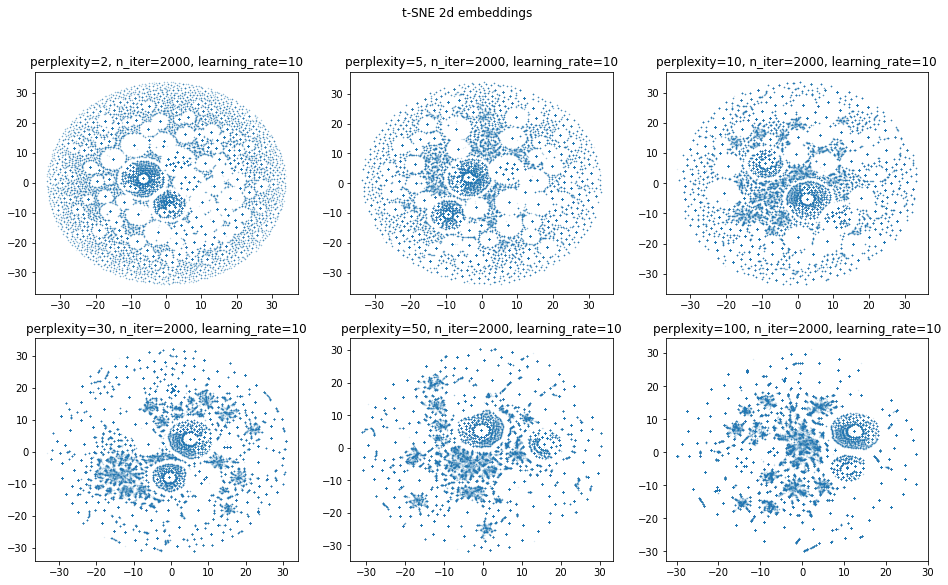

In [194]:
fig=plt.figure(figsize=(16,9))
fig.suptitle("t-SNE 2d embeddings")
for i, n in enumerate(perplexity_list):
    ax=fig.add_subplot(2,3,i+1)        
    ax.scatter(tsne_embed_list[i][ : ,0], tsne_embed_list[i][ : ,1], s=0.1, alpha=0.2)
    ax.set_title(f"perplexity={n}, n_iter=2000, learning_rate=10")

On subsequent projections, it can be noticed a better grouping of points along with the higher value of the `perpliexity` parameter.

### UMAP

UMAP (Uniform Manifold Approximation and Projection) is non-linear dimension reduction method that is used mainly for visualisation of multidimensional datasets (and clusters of datapoints). This method was created in 2018 as a general-purpose manifold learning and dimension reduction algorithm. UMAP can be define as similar to t-SNE (another **manifold** method) but it's faster and perform probably better visualization.

In our case as an input (pre-step) to UMAP algoritm we use data reduced by PCA in previous step (33-dim).

Useful information about umap library can be found on: https://umap-learn.readthedocs.io/en/latest/index.html

A background behind method widely presented in paper: https://arxiv.org/pdf/1802.03426v2.pdf

UMAP has different hyperparameters that can have an impact on the resulting embeddings, beneath main four of them:

`n_neighbors` parameter controls how UMAP balances local versus global structure in the data. This low values of n_neighbours forces UMAP to focus on very local structures while the higher values will make UMAP focus on the larger neighbourhoods.

`min_dist` parameter controls how tightly UMAP is allowed to pack points together. Lower values mean the points will be clustered closely and vice versa.

`n_components` parameter allows the user to determine the dimensionality of the reduced dimension space.

`spread` is the effective scale of embedded points. In combination with `min_dist` determines how seperated/clumped the points are.

From hints above we can conclude that in our case `n_neighbors` should be "big", `min_dist` should be "small" - as we'd like to obtain set of big and well-seperated clusters. `n_components` will be set to `2` as we want to present results on 2d plots. Is doesn't seem that `metric` parameter has a significat meaning, however we check differet ones.

In [119]:
# to "mute" warnings
import warnings
warnings.filterwarnings("ignore", category=Warning)

First tested parameter is `n_neighbors`. The higher values is, the more 'compressed' data points are. According to UMAP docs, reasonable values of `n_neighbors` are between 2 and 100.

In [159]:
n_neighbors_list = [2, 5, 10, 20, 50, 100]
umap_embed_list = []
for n_neighbors in n_neighbors_list:
    start_time = time.time()
    umap_embed = umap.UMAP(n_neighbors=n_neighbors, 
                           n_components=2,
                           min_dist=0.1,
                           spread=1.0,
                           metric='euclidean',
                           random_state=42,
                           n_epochs=20).fit_transform(X_s)
    print(f"n_neighbors={n_neighbors} {np.round(time.time() - start_time, 1)} seconds")
    umap_embed_list.append(umap_embed)

n_neighbors=2 461.9 seconds
n_neighbors=5 56.5 seconds
n_neighbors=10 37.5 seconds
n_neighbors=20 60.4 seconds
n_neighbors=50 151.6 seconds
n_neighbors=100 445.0 seconds


In [165]:
np.save(f"Data/umap_embeddigs_vs_n_neighbors.npy", umap_embed_list)

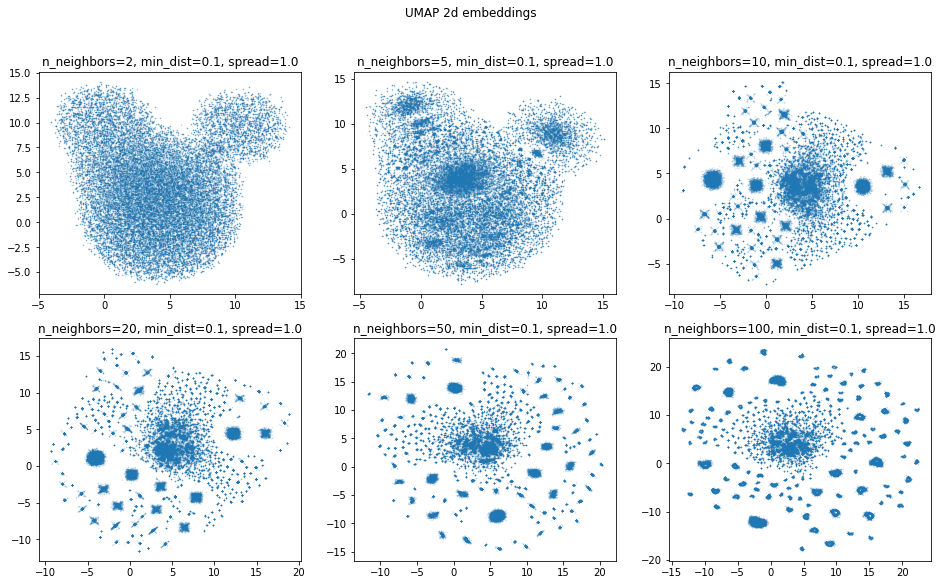

In [187]:
fig=plt.figure(figsize=(16,9))
fig.suptitle("UMAP 2d embeddings")
for i, n in enumerate(n_neighbors_list):
    ax=fig.add_subplot(2,3,i+1)        
    ax.scatter(umap_embed_list[i][ : ,0], umap_embed_list[i][ : ,1], s=0.1, alpha=0.2)
    ax.set_title(f"n_neighbors={n}, min_dist=0.1, spread=1.0")

It seems that the value of `n_neighbors = 50` is enough to group the points and reduce the number of points forming a "cloud" without clear densities. It should be remembered that a larger value of `n_neighbors` affects the length of algorithm calculations.

In [181]:
min_dist_spread_list = [(8, 10), (5, 10), (1, 10), (0.8, 1), (0.5, 1), (0.1, 1)]
umap_embed2_list = []
for min_dist_spread in min_dist_spread_list:
    start_time = time.time()
    umap_embed = umap.UMAP(n_neighbors=50, 
                           n_components=2,
                           min_dist=min_dist_spread[0],
                           metric='euclidean',
                           random_state=42,
                           spread=min_dist_spread[1],
                           n_epochs=20).fit_transform(X_s)
    print(f"min_dist={min_dist_spread[0]}, spread={min_dist_spread[1]} {np.round(time.time()-start_time, 1)} seconds")
    umap_embed2_list.append(umap_embed)

min_dist=8, spread=10 151.6 seconds
min_dist=5, spread=10 148.2 seconds
min_dist=1, spread=10 148.9 seconds
min_dist=0.8, spread=1 151.9 seconds
min_dist=0.5, spread=1 150.2 seconds
min_dist=0.1, spread=1 153.0 seconds


In [188]:
np.save(f"Data/umap_embeddigs_n_neighbors50_vs_min_dist_spread.npy", umap_embed2_list)

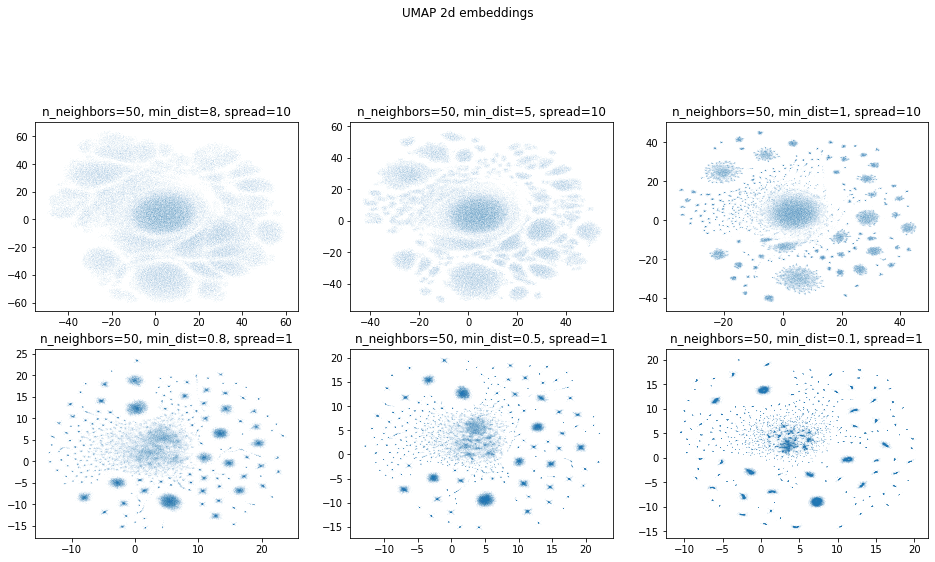

In [202]:
fig=plt.figure(figsize=(16,16))
fig.suptitle("UMAP 2d embeddings")
for i, n in enumerate(min_dist_spread_list):
    ax=fig.add_subplot(4,3,i+1)        
    ax.scatter(umap_embed2_list[i][ : ,0], umap_embed2_list[i][ : ,1], s=0.01, alpha=0.1)
    ax.set_title(f"n_neighbors=50, min_dist={n[0]}, spread={n[1]}")

In the above plots, it seems that the best choice (in terms of clustering) will be the default values of the parameters `min_dist = 0.1` and `spread = 1`. Each group of points is here better 'condensed' and better separated from other clusters. It should be noted that in the area in the center of the plot for parameters `min_dist = 0.1` and `spread = 1` we can distinct a few separeted clusters.

Last step in this chapter will be projecting whole data set on 2D plot with optimal parameters.

In [195]:
umap_embed = umap.UMAP(n_neighbors=50, 
                           n_components=2,
                           min_dist=0.1,
                           metric='euclidean',
                           random_state=42,
                           spread=1,
                           n_epochs=20).fit_transform(X_pca)
np.save("Data/umap_embeddigs_alldata_nn50_md01.npy", umap_embed)

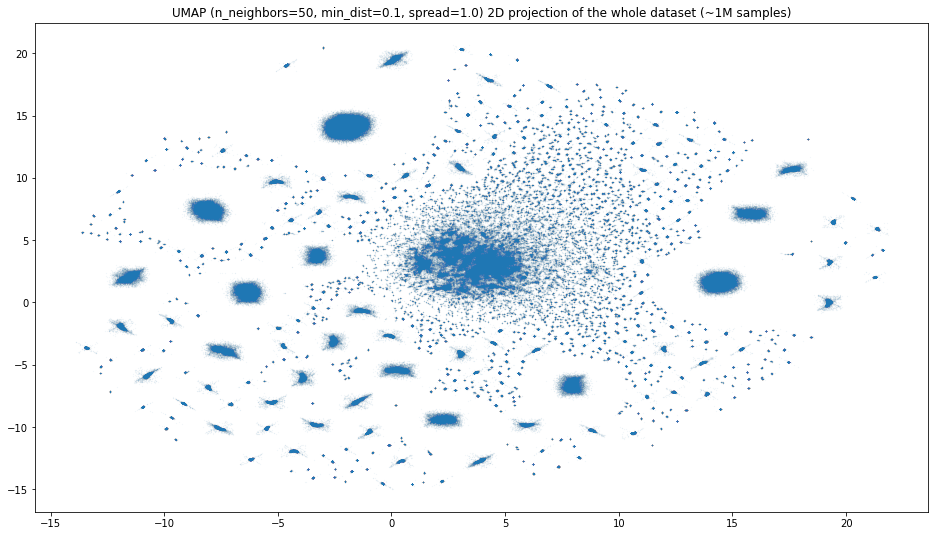

In [201]:
plt.figure(figsize=(16,9))
plt.scatter(umap_embed[ : ,0], umap_embed[ : ,1], s=0.05, alpha=0.1)
plt.title('UMAP (n_neighbors=50, min_dist=0.1, spread=1.0) 2D projection of the whole dataset (~1M samples)')
plt.show()

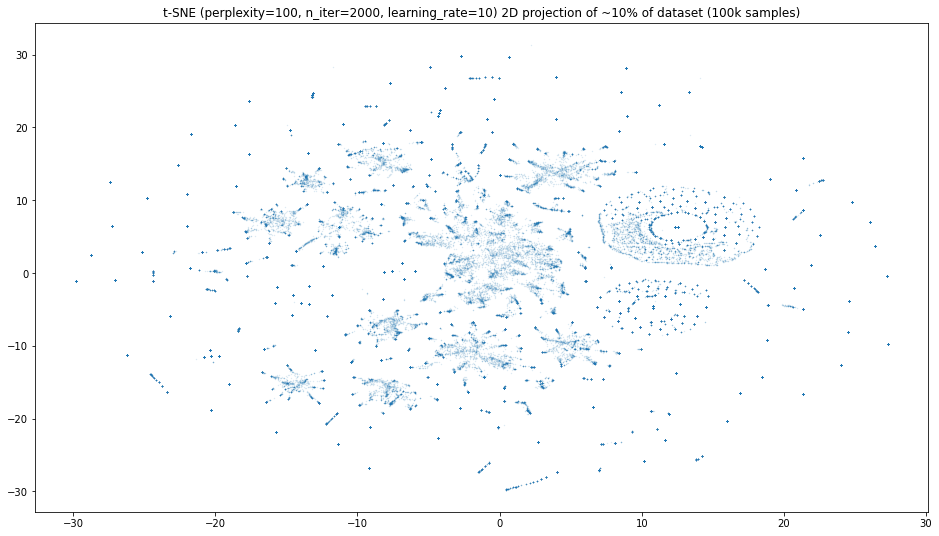

In [199]:
plt.figure(figsize=(16,9))
plt.scatter(tsne_embed_list[5][ : ,0], tsne_embed_list[5][ : ,1], s=0.1, alpha=0.2)
plt.title('t-SNE (perplexity=100, n_iter=2000, learning_rate=10) 2D projection of ~10% of dataset (100k samples)')
plt.show()

As can be seen in the above charts, the in the UMAP projection plot we can distinguish the main clusters of points with the naked eye. Emmbedding obtained using t-SNE are arranged in a slightly more diffuse manner, although individual groups can be caught here. Unfortunately, in the case of the discussed problem, the t-SNE algorithm revealed its disadvantage in the form of computational complexity. Using it for the entire data set would not allow results to be obtained in a "reasonable" time.

# 3. Clustering
Once we have prepared and selected (subjectively) best representation of origial dataset here comes main point of task: clustering. 

Due to shape of datapoint groups (on 2d plot) it seems that partitioning method won't be the best choice. Regarding discussed clustering problem we are going to use two methods:
- partitioning (K-Means) as a baseline
- density-baser (DBSCAN)
- improved density-based (HDBSCAN)

To choose best algotithm (and its hyperparameters) we need quality measures. As unsupervised machine learning problems don't contain gound truth labels validating them is quite tricky and requires also manual (human eye) evaluation. 
There are many examples of clustering manuals based on well-known classification data sets (for example: iris, MNIST, wine, etc.) where clusters determined by algorithm are compared with true labels. Unfortunately assesment of clstering results in real life problems (like one discussed in this project) is based mainly on visual assesment. That's why choosing the best 2D-respresentation of data points (in the previous step) was so important.

Checkpoint

In [2]:
# Loading data - 2D projection made by UMAP
umap_embed = np.load('Data/umap_embeddigs_alldata_nn50_md01.npy')
umap_embed.shape

(989818, 2)

24

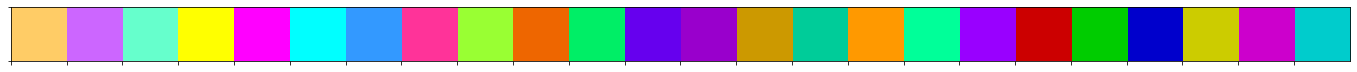

In [3]:
# we need a palette of distinctive colors to mark points with labels assigned by algorithm
my_palette = ["#ffcc66", "#cc66ff", "#66ffcc", "#ffff00", "#ff00ff", "#00ffff",\
              "#3399ff", "#ff3399", "#99ff33", "#ee6600", "#00ee66", "#6600ee",\
              "#9900cc", "#cc9900", "#00cc99", "#ff9900", "#00ff99", "#9900ff",\
              "#cc0000", "#00cc00", "#0000cc", "#cccc00", "#cc00cc", "#00cccc"]
sns.palplot(sns.color_palette(my_palette))
len(my_palette)

In [4]:
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    print("Clustering took:", np.round(end_time-start_time, 1), "s")
    palette = sns.color_palette(my_palette, np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.figure(figsize=(16,9))
    plt.scatter(data[:,0], data[:,1], c=colors, s=0.01, alpha=1.0)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title(f'Clusters found by {algorithm.__name__}', fontsize=12)
    return labels

### K-Means
Well known and broadly used partitioning method. When it comes to cluster data, K-Means is mostly first choice. But we have to remamber that this mehtod is actually partitioning algorithm. What K-Means do is to split data into given (expected by user) number of chunks to minimize intra-cluster distances. Unfortunatelly algorithm does not detect outliers and (what worse, in our case) we have to experimentally find 'proper' value of `n_clusters`.  

First we determine the number of clusters using the inertia value (elbow rule).

In [277]:
kmeans_n_clusters_list = range(10,41)
inertia_list = []
for n_clusters in kmeans_n_clusters_list:
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=2000)
    start_time = time.time()
    kmeans.fit(umap_embed)
    print(f"n_clusters: {n_clusters}  {np.round(time.time()-start_time, 1)} seconds")
    inertia_list.append(kmeans.inertia_)

n_clusters: 10  0.5 seconds
n_clusters: 11  0.6 seconds
n_clusters: 12  1.2 seconds
n_clusters: 13  1.7 seconds
n_clusters: 14  1.5 seconds
n_clusters: 15  2.6 seconds
n_clusters: 16  1.8 seconds
n_clusters: 17  3.0 seconds
n_clusters: 18  2.1 seconds
n_clusters: 19  2.7 seconds
n_clusters: 20  1.1 seconds
n_clusters: 21  2.7 seconds
n_clusters: 22  1.2 seconds
n_clusters: 23  2.6 seconds
n_clusters: 24  1.2 seconds
n_clusters: 25  2.1 seconds
n_clusters: 26  3.4 seconds
n_clusters: 27  3.5 seconds
n_clusters: 28  1.4 seconds
n_clusters: 29  1.4 seconds
n_clusters: 30  3.7 seconds
n_clusters: 31  3.1 seconds
n_clusters: 32  3.6 seconds
n_clusters: 33  3.6 seconds
n_clusters: 34  4.2 seconds
n_clusters: 35  1.8 seconds
n_clusters: 36  4.5 seconds
n_clusters: 37  4.1 seconds
n_clusters: 38  3.1 seconds
n_clusters: 39  3.9 seconds
n_clusters: 40  2.2 seconds


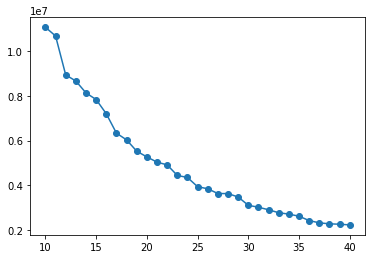

In [278]:
plt.plot(kmeans_n_clusters_list, inertia_list, "-o")
plt.show()

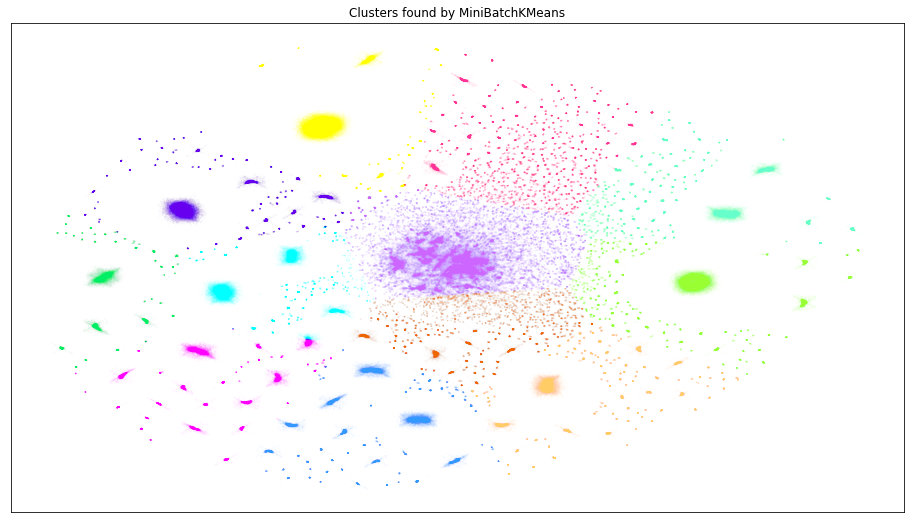

In [295]:
plot_clusters(umap_embed, MiniBatchKMeans, (), {'n_clusters':12, 'batch_size':1000})

The second approach to determining the optimal number of clusters is the Silhouette Score.

In [7]:
kmeans_n_clusters_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
silhouette_list = []

for n_clusters in kmeans_n_clusters_list:
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=2000)
    #start_time = time.time()
    kmeans_labels = kmeans.fit_predict(umap_embed)
    silhouette_list.append( silhouette_score(umap_embed[::100], kmeans_labels[::100]) )
    #print(f"n_clusters: {n_clusters}  {np.round(time.time()-start_time, 1)} seconds")

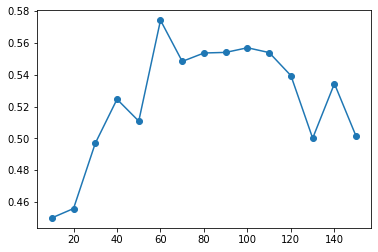

In [9]:
plt.plot(kmeans_n_clusters_list, silhouette_list, "-o")
plt.show()

Clustering took: 1.0 s


array([ 5, 14, 17, ..., 39, 53,  4])

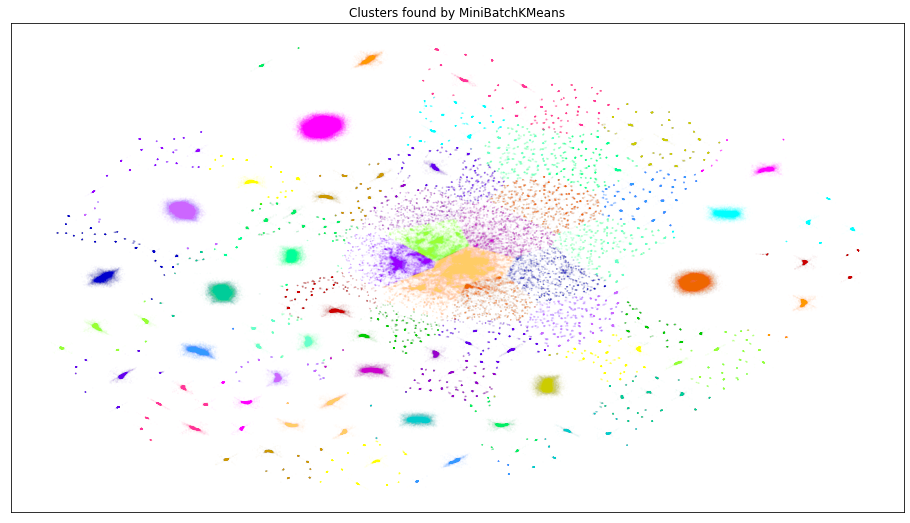

In [12]:
plot_clusters(umap_embed, MiniBatchKMeans, (), {'n_clusters':60, 'batch_size':1000})

Clustering (actually - partitioning) results does not meet our expectations. Neither number of clusters determined by 'elbow rule' on the inertia plot (12) nor that specified by Silhouette Score (~75) distinguishes each high density groups of points. Such a cluster has to be faw away from others for KMeans to mark it correctly. 

It's definityly not the way we want to search meaningful clusters in examinated data set.

### DBSCAN
DBSCAN stands for Density-Based Spatial Clustering of Applications with Noise. This mothod is able to find arbitrary shaped clusters and clusters with noise (i.e. outliers, anomalies). The main idea behind DBSCAN is that a point belongs to a cluster if it is close to 'many' other points from that cluster.

There are two key parameters of DBSCAN:
- `eps` - the distance that specifies the neighborhoods. Two points are considered to be neighbors if the distance between them are less than or equal to eps.
- `min_samples` - minimum number of samples in a neighborhood for a point to be considered as a core point.

Clustering took: 247.1 s


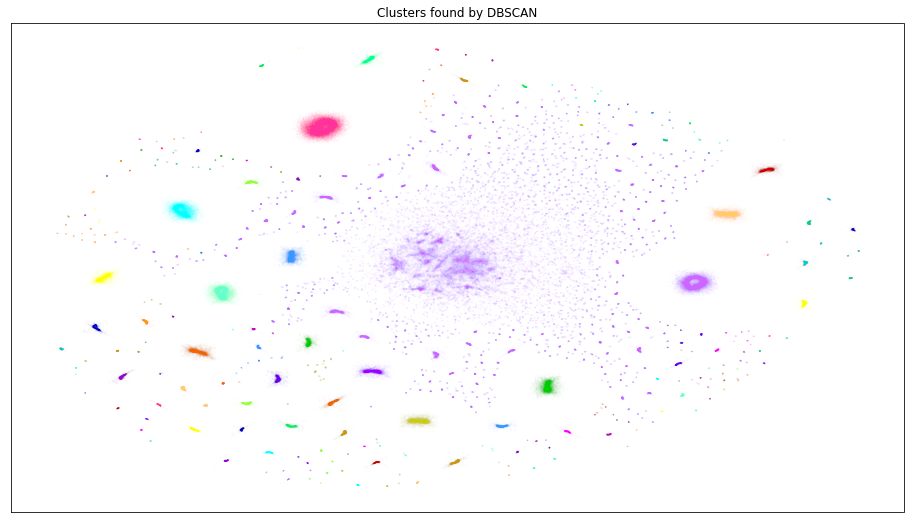

In [11]:
# Searching values of hyperparameter that optimise 
dbscan_labels = plot_clusters(umap_embed[::3], DBSCAN, (), {'eps':0.5, 'min_samples':5, 'leaf_size':30, 'n_jobs':6})

Clustering took: 254.3 s


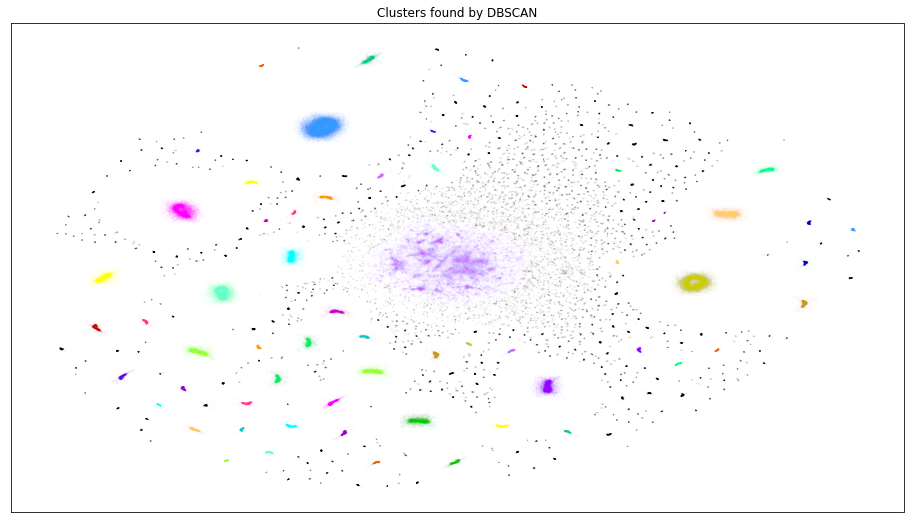

In [12]:
dbscan_labels = plot_clusters(umap_embed[::3], DBSCAN, (), {'eps':0.5, 'min_samples':500, 'leaf_size':30, 'n_jobs':6})

Clustering took: 294.3 s


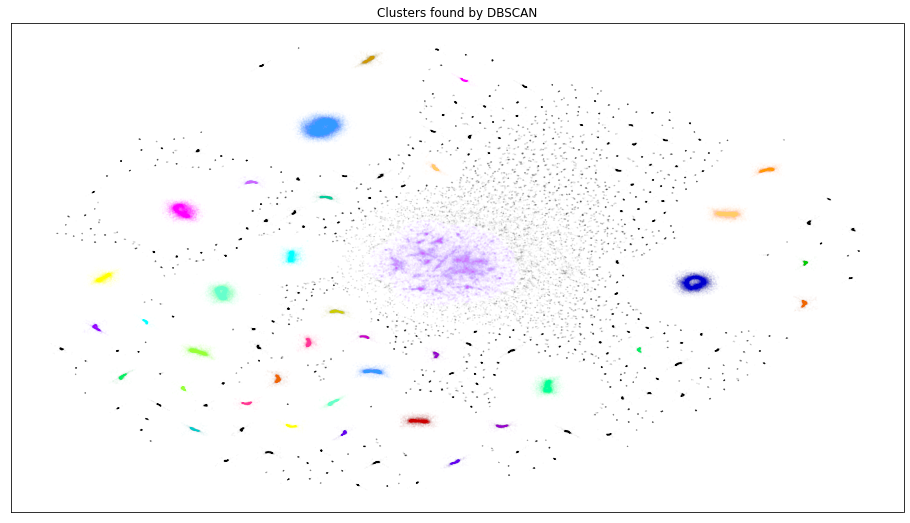

In [13]:
dbscan_labels = plot_clusters(umap_embed[::3], DBSCAN, (), {'eps':0.6, 'min_samples':1000, 'leaf_size':30, 'n_jobs':6})

In [16]:
print('number of clusers found by DBSCAN: ', np.unique(dbscan_labels).max() )

number of clusers found by DBSCAN:  36


Using the DBSCAN algorithm in the discussed problem, it was possible to determine the clusters of points with the highest density and correctly separate them from the others. Moreover, the algorithm does not try to assign all points to clusters. Points with `labels=-1` are treated as ouliers (black dots on plot). Unfortunately, the disadvantages of DBSCAN are revealed here, namely **not intuitive hyperparameters** and **calculation time**. We could not to processed whole data set in reasonable time.

### HDBSCAN
The goal of HDBSCAN is to allow varying density clusters. The algorithm starts off much the same as DBSCAN: we transform the space according to density, exactly as DBSCAN does, and perform single linkage clustering on the transformed space. Instead of taking an epsilon value as a cut level for the dendrogram however, a different approach is taken: the dendrogram is condensed by viewing splits that result in a small number of points splitting off as points ‘falling out of a cluster’. This results in a smaller tree with fewer clusters that ‘lose points’. That tree can then be used to select the most stable or persistent clusters. This process allows the tree to be cut at varying height, picking our varying density clusters based on cluster stability.

We will tune performance of HDBSCAN with parameters below:
- `min_cluster_size` - determines minimal number of samples to form a new cluster, it replaced less intuitive `eps` in DBSCAN, the higher value of `min_cluster_size` is - the less clusters we can expect, 
- `min_samples` provides a measure of how 'conservative' clustering will be. The larger the value of min_samples – the more points will be declared as noise, and clusters will be restricted to progressively more dense areas.

Intuitively, we set minimal number samples to form a cluster to `min_sample_size=1000` and `min_samples=500` (as a half of `min_sample_size`).

Clustering took: 204.4 s


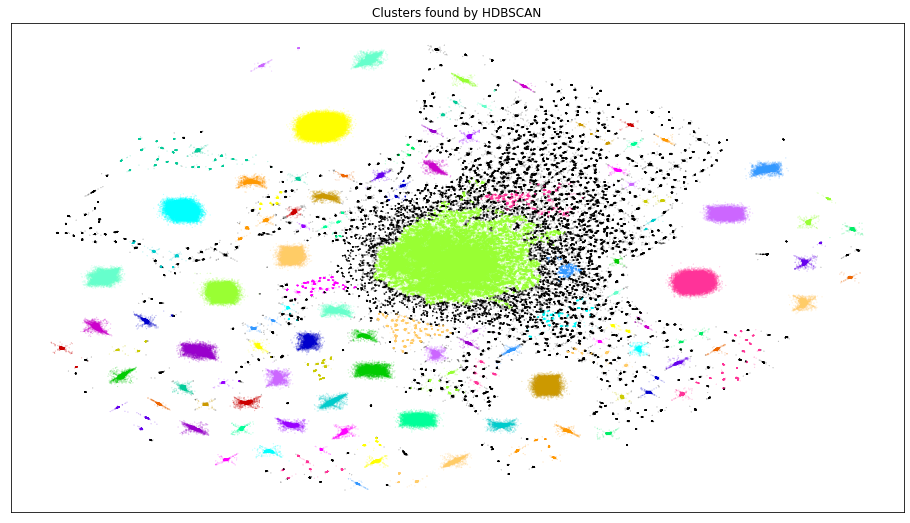

In [5]:
hdbscan_labels_baseline = plot_clusters(umap_embed, hdbscan.HDBSCAN, (), \
                               {'min_cluster_size':1000, 'min_samples':500, 'core_dist_n_jobs':4})

In [7]:
print("Number of clusters found: ", np.unique(hdbscan_labels_baseline).max() )
noise_points = hdbscan_labels_baseline[hdbscan_labels_baseline==-1].shape[0]
print(f"Number of 'noise' points: {noise_points}, {np.round(noise_points/umap_embed.shape[0]*100, 1)}% of data set" )

Number of clusters found:  104
Number of 'noise' points: 162847, 16.5% of data set


In [11]:
cluster_label, cluster_counts = np.unique(hdbscan_labels_baseline, return_counts=True)
plt.figure(figsize=(16,3))
plt.bar(cluster_label, cluster_counts)
plt.yscale('log')
plt.title('Number of elements in clusters (log scale)')
plt.show()

NameError: name 'hdbscan_labels_baseline' is not defined

Results of clustering whole data set looks good, but there are few things we could improve. We may filter out small clusters by increasing `min_cluster_size`. Let's double it: 

Clustering took: 220.7 s


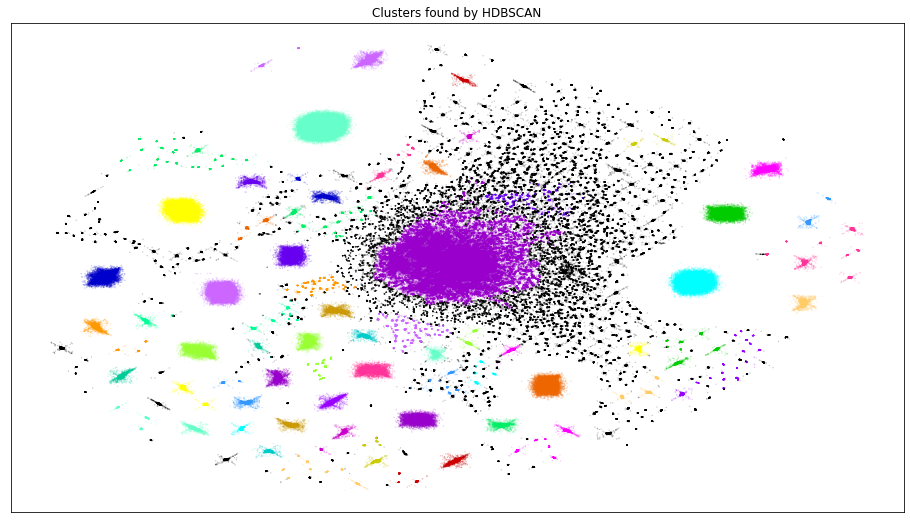

In [8]:
hdbscan_labels_improve = plot_clusters(umap_embed, hdbscan.HDBSCAN, (), \
                               {'min_cluster_size':2000, 'min_samples':500, 'core_dist_n_jobs':4})

In [9]:
print("Number of clusters found: ", np.unique(hdbscan_labels_improve).max() )
noise_points = hdbscan_labels_improve[hdbscan_labels_improve==-1].shape[0]
print(f"Number of 'noise' points: {noise_points}, {np.round(noise_points/umap_embed.shape[0]*100, 1)}% of data set" )

Number of clusters found:  60
Number of 'noise' points: 197008, 19.9% of data set


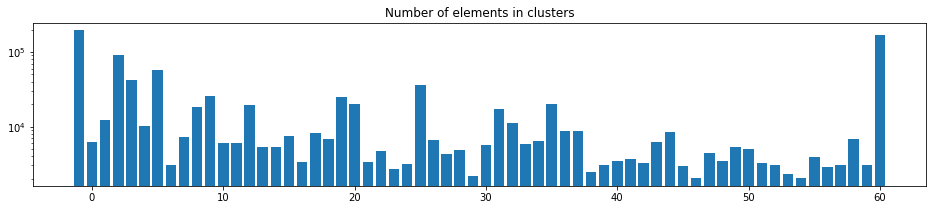

In [22]:
cluster_label, cluster_counts = np.unique(hdbscan_labels_improve, return_counts=True)
plt.figure(figsize=(16,3))
plt.bar(cluster_label, cluster_counts)
plt.yscale('log')
plt.title('Number of elements in clusters (log scale)')
plt.show()

Clustering took: 187.8 s


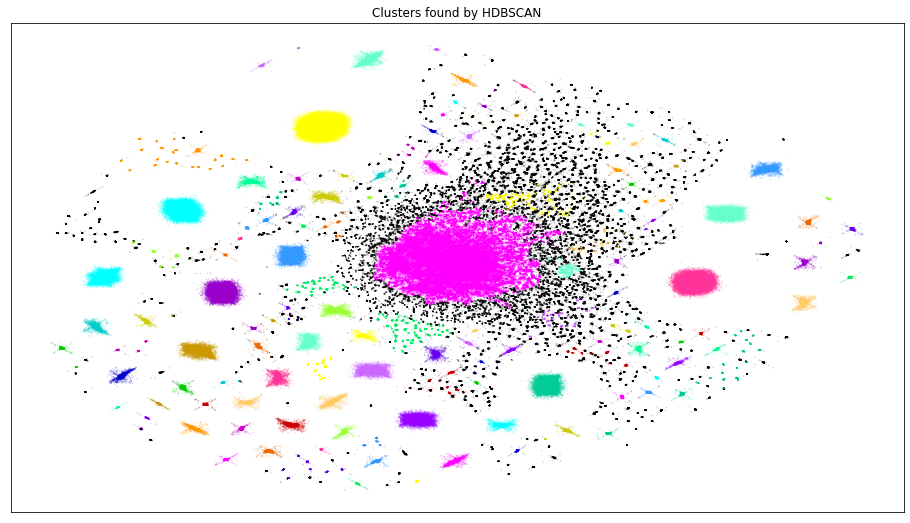

In [5]:
hdbscan_labels_improve2 = plot_clusters(umap_embed, hdbscan.HDBSCAN, (), \
                               {'min_cluster_size':700, 'min_samples':500, 'core_dist_n_jobs':4})

In [7]:
print("Number of clusters found: ", np.unique(hdbscan_labels_improve2).max() )
noise_points = hdbscan_labels_improve2[hdbscan_labels_improve2==-1].shape[0]
print(f"Number of 'noise' points: {noise_points}, {np.round(noise_points/umap_embed.shape[0]*100, 1)}% of data set" )

Number of clusters found:  124
Number of 'noise' points: 159154, 16.1% of data set


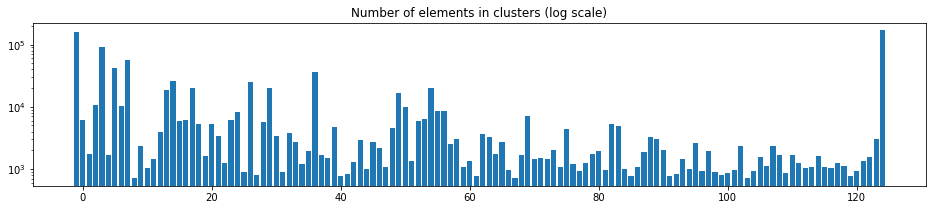

In [10]:
cluster_label, cluster_counts = np.unique(hdbscan_labels_improve2, return_counts=True)
plt.figure(figsize=(16,3))
plt.bar(cluster_label, cluster_counts)
plt.yscale('log')
plt.title('Number of elements in clusters (log scale)')
plt.show()

Checkopint

In [9]:
np.save('Data/hdbscan_labels_improve2.npy', hdbscan_labels_improve2)

# 4. Interpretation of results
And here comes the main reason why the data processing above was carried out. We actually would like to draw some conclusions from obtained results. So far we processed data and presented it on 2D graphs - an abstraction. It's time to go back to real and take 361-dimensional data set representing each session as a ransition matrix (*Markov Chains concept*).

In [92]:
X = sp.load_npz("Data/X_sparse.npz")
type(X), X.shape

(scipy.sparse.csr.csr_matrix, (989818, 361))

In [94]:
# transitions between pages, 0-START of SESSION, 18-END of SESSION, rest of nubmbers identical as in original raw data
transitions = features[features_idx]
transitions[:20]

array([(0,  0), (0,  1), (0,  2), (0,  3), (0,  4), (0,  5), (0,  6),
       (0,  7), (0,  8), (0,  9), (0, 10), (0, 11), (0, 12), (0, 13),
       (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (1,  0)],
      dtype=[('current', '<i8'), ('next', '<i8')])

First let's prepare an 'average sesion' representation for each cluster. Since now when we mention 'cluster' it means average values of probabilities for sessions in particular cluster.

In [127]:
# we drop label -1 which stands for unclassified data points to any cluster 
cluster_labels = np.unique(hdbscan_labels_improve2)[1:]
cluster_avg_list = [] # list of 'average sessions' (per cluster)
cluster_qty_list = [] # list of element quantities (per cluster)
for label in cluster_labels:
    ids = hdbscan_labels_improve2==label
    records = X[ids, :]
    qty = X[ids, :].shape[0]
    cluster_qty_list.append( qty )
    cluster_avg_list.append(np.asarray(records.sum(0)).flatten() / qty )
cluster_qty_list = np.array(cluster_qty_list)
cluster_avg_list = np.array(cluster_avg_list)
cluster_avg_list.shape

(125, 361)

Here we present few examplary clusters on barplots. Hight of each bar is an average 'transition probability' among all data points in the cluster.

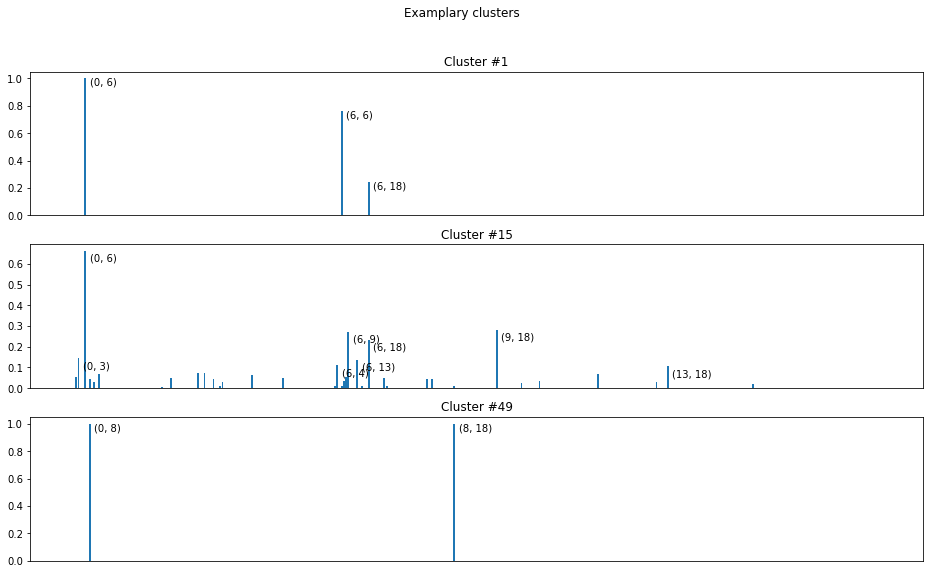

In [148]:
fig=plt.figure(figsize=(16,9))
fig.suptitle("Examplary clusters")
for i, n in enumerate([1,15,49]):
    ax=fig.add_subplot(3,1,i+1)        
    ax.bar(range(361), cluster_avg_list[n])
    # annotation of bars higher that 0.1
    for i, h in enumerate(cluster_avg_list[n]):
        if h > 0.1: ax.text(i+2, h-0.05, str(transitions[i]))
    ax.set_title(f"Cluster #{n}")
    ax.get_xaxis().set_visible(False)

We can distinguish three types of clusters:
- with 2 transitions (0, x) and (x, 18) - each equals 1.0 - this represents sessions where only category page was visited;
- with 3 transitions (0, x), (x, x), (x, 18) - this represents sessions where one (and only one) category was visted more that once;
- with more than 3 transitions - this represents all other sessions where more that one category was visited.

Two first groups we can name as a 'pure' ones - user was interested in only one category on msnbc.com. Below we try to determine the number of each cluster group above.

In [154]:
transitions_qty = [] # list of transitions number in each cluster (s)
for cluster_avg in cluster_avg_list:
    # sum of non zero positions -> sum of visited pages
    transitions_qty.append( (cluster_avg > 0).sum() )
transitions_qty = np.array(transitions_qty)
print( "Number of clusters where was visited only one category: ", (transitions_qty == 2).sum() )
print( "Number of clusters where was visited only one category (more that once): ", (transitions_qty == 3).sum() )
print( "Number of clusters where was visited more than one category: ", (transitions_qty >  3).sum() )

Number of clusters where was visited only one category:  11
Number of clusters where was visited only one category (more that once):  51
Number of clusters where was visited more than one category:  63


Surprisingly, nearly a half of clusters are 'pure'. Beneath we present analisys of that clusters.

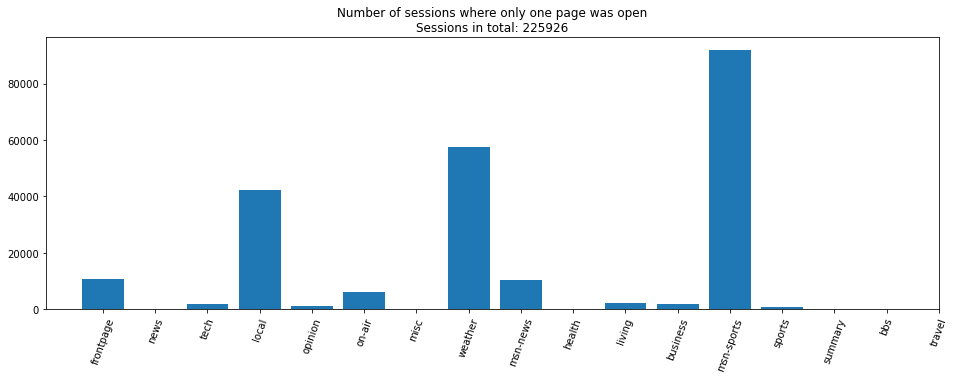

In [176]:
# take all clusters where was 2 transitions -> one page visited only once
# take first non-zero element to determine category number index
cat_A_list = np.nonzero(cluster_avg_list[transitions_qty==2])[1][::2]
idx_A_list = np.nonzero(cluster_avg_list[transitions_qty==2])[0][::2]

plt.figure(figsize=(16,5))
plt.title(f'Number of sessions where only one page was open\nSessions in total: {cluster_qty_list[idx_A_list].sum()}')
plt.bar(cat_A_list, cluster_qty_list[idx_A_list])
plt.xticks(range(1,18), categories, rotation=70)
plt.show()

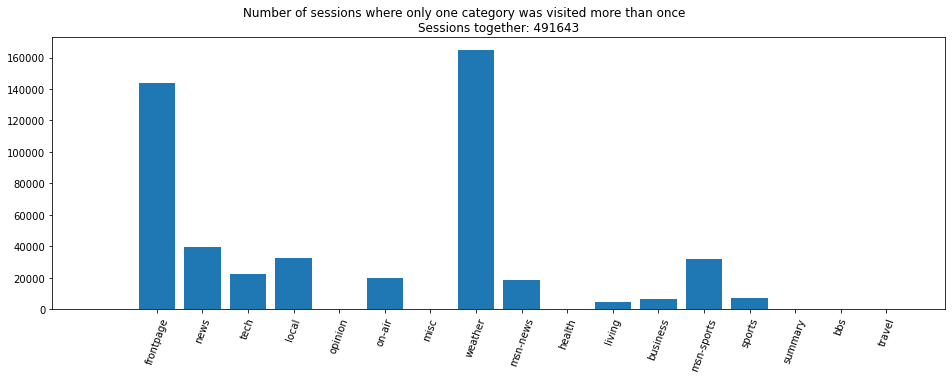

In [194]:
# take all clusters where was 3 transitions -> one category visited more than once
# take first non-zero element to determine category number index
cat_B_list = np.nonzero(cluster_avg_list[transitions_qty==3])[1][::3]
idx_B_list = np.nonzero(cluster_avg_list[transitions_qty==3])[0][::3]
# as there are 51 such a clusters it is obvious that page categories (viewed during session) repete among clusters 
# need to sum number of sessions in each category among clusters
cat_B_qty_list = np.zeros(18)
for i, cat in enumerate(cat_B_list):
    #print( cat )
    cat_B_qty_list[cat] += cluster_qty_list[idx_B_list[i]]
    
plt.figure(figsize=(16,5))
plt.title(f'Number of sessions where only one category was visited more than once  \
                \nSessions together: {cluster_qty_list[idx_B_list].sum()}')
plt.bar(range(18), cat_B_qty_list.flatten())
plt.xticks(range(1,18), categories, rotation=70)
plt.show()

And there comes most interesting type of clusters - where during a session multiple page categories was open.

In [ ]:
categories_ext = categories.copy()
categories_ext.append('END')
categories_ext.insert(0, 'START')

In [317]:
def plot_heatmaps(data, labels=categories_ext):
    # plots grid of heatmaps for each row in input 'data' np.array
    n_cols = 2
    n_rows = int(np.ceil( data.shape[0]/n_cols ))
    fig=plt.figure(figsize=(8*n_cols, 8*n_rows))
    for i, row in enumerate(data):
        ax  = fig.add_subplot(n_rows,n_cols,i+1)        
        arr = row.reshape(19,-1)
        sns.heatmap(ax=ax, 
                    data=arr, 
                    yticklabels=categories_ext, 
                    xticklabels=categories_ext, 
                    linewidths=0.2, 
                    annot=True,
                    cbar=False)
    plt.plot()

On heatmaps below we can see average transitions between categories per cluster in third type of cluster (where more than one category page was visited during session). 

How to read these matrices? Row indecies stands for 'FROM' category, and column indicies stands for 'TO' category. Values on heatmap (with color scale) stands for average probability (in cluster) of transition between categories 'FROM'->'TO'. 

We can notice that there are several clusters which could be consider as "only one page" or "only one category more than once" - where rest of transitions values is near to 0. This result is caused most probably by accuracy of dimensionality reduction and/or clustering.

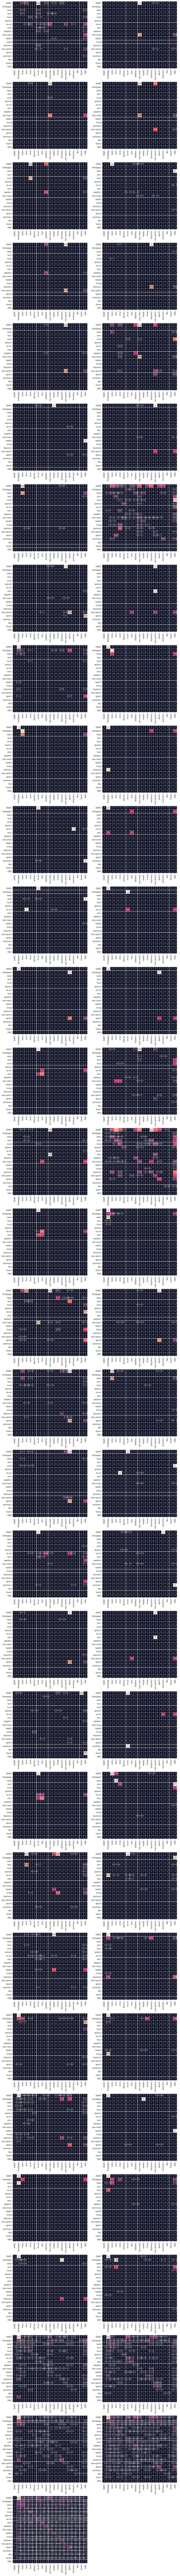

In [318]:
plot_heatmaps(cluster_avg_list[transitions_qty >3])